# End to end papermill test


## Import the Gradient Client

In [1]:
#Import the SdkClient from the gradient package
from gradient import sdk_client
import os
from gradient import constants
import re
from time import sleep

### This is tagged with "parameters" 

Run with the following command:

bash dev_env.sh && papermill vpc_nb_tests.ipynb ./vpc_nb_output.ipynb -p project # -p api_key # -cluster # 

In [ ]:
#create a API Key
api_key = "#"
project = "#"
cluster = "#"

Error: Error: Failed to connect to remote Jupyter notebook.
Check that the Jupyter Server URI setting has a valid running server specified.
https://n0uzmy8n.gradient.paperspace.com/
TypeError: request to https://n0uzmy8n.gradient.paperspace.com/api/contents/?1580874142484 failed, reason: connect ECONNREFUSED 92.242.140.21:443

In [3]:
client = sdk_client.SdkClient(api_key)

#or access them all from a single client
deployment_client = sdk_client.DeploymentsClient(api_key)
models_client = sdk_client.ModelsClient(api_key)
jobs_client = sdk_client.JobsClient(api_key)
projects_client = sdk_client.ProjectsClient(api_key)
experiment_client = sdk_client.ExperimentsClient(api_key)

from gradient.api_sdk.clients import tensorboards_client
tb_client = tensorboards_client.TensorboardClient(api_key)

## Create a project

In [4]:
#enable incremental runs against same cluster w/ same naming convention
def get_name_prefix():
    name_prefix = "\d-nbval"
    run = 1
    exp_in_project = client.experiments.list(project_id = project)
    exps_nbval = list(filter(lambda x: re.match(name_prefix, x.name), exp_in_project))
    if exps_nbval != []:
        run = max(list(map(lambda x: int(x.name[0]), exps_nbval))) +1             
    prefix = str(run)+"-nbval"
    return prefix

prefix = get_name_prefix()

In [6]:
#check if project exists otherwise make it
def make_project():
    projects = client.projects.list()
    print(projects)
    if project not in list(map(lambda x: x.name, projects)):
        project_id = client.projects.create(project)
        return project_id
    return project
#project = make_project()
#print("using project: " +project)

In [7]:
experiments_list = []

In [8]:
from gradient import s3_uploader

bucket = "s3://ps-projects-development/teo6raui0/prda8mhcq/689c67dc/fashion.zip"
if bucket == None:
    uploader = s3_uploader.S3ProjectFileUploader(api_key)
    bucket = uploader.upload('./fashion-mnist.zip', project)
print(bucket)

s3://ps-projects-development/teo6raui0/prda8mhcq/689c67dc/fashion.zip


## Helper function to run an Experiment

In [6]:
def run_single_node(project, cluster, experiments_list):
    env = {
        "EPOCHS_EVAL":"10",
        "TRAIN_EPOCHS":"40",
        "MAX_STEPS":"50000",
        "EVAL_SECS":"600",
        "BATCH_SIZE":"100",
        
    }

    single_node_parameters = { 
        "name": "single-node-peloton",
        "project_id": project,
        "container": "tensorflow/tensorflow:1.13.1-py3",
        "machine_type": "p2.xlarge",
        "command": "pip install -r requirements.txt && python mnist.py",
        "experiment_env": env,
        "workspace_url": "https://github.com/Paperspace/mnist-sample.git", #can be local directory, a git repo or commit, or s3 bucket
        "cluster_id" : cluster,
        "model_type" : "Tensorflow",
        "model_path" : "/artifacts"
    }
    #pass dictionary into experiments client

    experiment_id = client.experiments.run_single_node(**single_node_parameters)
    
    print(client.experiments.get(experiment_id))


    print("https://www.paperspace.com/console/projects/"+project+"/experiments/" + experiment_id)

    experiments_list += [experiment_id]

In [7]:
run_single_node(project, cluster, experiments_list)

{'name': 'single-node-peloton', 'project_id': 'pr5lw4j0g', 'container': 'tensorflow/tensorflow:1.13.1-py3', 'machine_type': 'p2.xlarge', 'command': 'pip install -r requirements.txt && python mnist.py', 'experiment_env': {'EPOCHS_EVAL': '10', 'TRAIN_EPOCHS': '40', 'MAX_STEPS': '50000', 'EVAL_SECS': '600', 'BATCH_SIZE': '100'}, 'workspace_url': 'https://github.com/Paperspace/mnist-sample.git', 'cluster_id': 'clu7jqg9j', 'model_type': 'Tensorflow', 'model_path': '/artifacts'}
SingleNodeExperiment(name='single-node-peloton', ports='5000:5000', workspace_url='https://github.com/Paperspace/mnist-sample.git', workspace_ref=None, workspace_username=None, workspace_password=None, datasets=None, working_directory=None, artifact_directory=None, cluster_id='clu7jqg9j', experiment_env={'BATCH_SIZE': '100', 'EPOCHS_EVAL': '10', 'EVAL_SECS': '600', 'MAX_STEPS': '50000', 'TRAIN_EPOCHS': '40'}, project_id='pr5lw4j0g', model_type='Tensorflow', model_path='/artifacts', is_preemptible=False, id='e7wzxypxu

In [13]:
def run_multi_node_mpi(project, cluster, experiments_list):
    multi_node_parameters = { 
        "name": prefix+"-mpi-tensorflow",
        "project_id": project,
        "worker_container": "horovod/horovod:0.18.1-tf1.14.0-torch1.2.0-mxnet1.5.0-py3.6",
        "worker_machine_type": "p2.xlarge",
        "worker_command": "sleep infinity",
        "worker_count": 2,
        "master_container": "horovod/horovod:0.18.1-tf1.14.0-torch1.2.0-mxnet1.5.0-py3.6",
        "master_machine_type": "p2.xlarge",
        "master_command": "mpirun --allow-run-as-root -np 1 --hostfile /generated/hostfile  -bind-to none -map-by slot  -x NCCL_DEBUG=INFO -mca pml ob1 -mca btl ^openib python mnist_keras.py",
        "master_count": 1,
        "workspace_url": "https://github.com/Paperspace/horovod-distributed-example.git",
        "model_type": "Tensorflow",
        "use_vpc" : True,
        "cluster_id" : cluster,
    }
    experiment_id = client.experiments.run_mpi_multi_node(**multi_node_parameters)
    print("https://www.paperspace.com/console/projects/"+project+"/experiments/" + experiment_id)
    
    experiments_list += [experiment_id]

In [10]:
def run_multi_node_grpc(project, cluster, experiments_list):
    env = {
        "EPOCHS_EVAL":"10",
        "TRAIN_EPOCHS":"40",
        "MAX_STEPS":"50000",
        "EVAL_SECS":"600",
        "BATCH_SIZE":"100"
    }

    multi_node_parameters = { 
        "name": prefix+"-grpc",
        "project_id": project,
        "experiment_type_id": 2, #GRPC
        "worker_container": "tensorflow/tensorflow:1.13.1-gpu-py3",
        "worker_machine_type": "p2.xlarge",
        "worker_command": "pip install -r requirements.txt && python mnist.py",
        "experiment_env": env,
        "worker_count": 2,
        "parameter_server_container": "tensorflow/tensorflow:1.13.1-py3",
        "parameter_server_machine_type": "c5.xlarge",
        "parameter_server_command": "pip install -r requirements.txt && python mnist.py",
        "parameter_server_count": 1,
        "workspace_url": "https://github.com/Paperspace/mnist-sample.git",
        "cluster_id" : cluster,
        "use_vpc" : True,
        "model_type" : "Tensorflow",
    }

    #pass dictionary into experiments client
    experiment_id = client.experiments.run_multi_node(**multi_node_parameters)
    client.experiments.get(experiment_id)
    print("https://www.paperspace.com/console/projects/"+project+"/experiments/" + experiment_id)
    
    experiments_list += [experiment_id]

## State & Log Helpers 

In [10]:
def wait_for_end(experiment_id):
    print("Watching state of experiment: "+experiment_id)
    state = ""
    while state != "stopped":
         state= constants.ExperimentState.get_state_str(client.experiments.get(experiment_id).state)

In [11]:
def check_logs(experiments_list):
    for exp in experiments_list:
        logs = client.experiments.logs(exp)
        if len(logs) > 0:
            print("logs for experiment: "+ exp +" found")
            print(logs[:10])
        else:
            print("#########")
            print("no logs found for experiment: "+exp)

def capture_screenshots(experiment_id):
    print("capture gifs")

## Run the experiments

In [33]:
run_single_node(project, cluster, experiments_list)

In [14]:
run_multi_node_mpi(project, cluster, experiments_list)

https://www.paperspace.com/console/projects/prcl68pnk/experiments/ei5jmee643fmi


In [11]:
run_multi_node_grpc(project, cluster, experiments_list)

https://www.paperspace.com/console/projects/prcl68pnk/experiments/eskul3wj5t7jl


In [ ]:
#print(experiments_list)

In [16]:
print("adding to tensorboard")
tb_id = tb_client.create(experiments=experiments_list)

adding to tensorboard


## Wait for Experiments to end

In [ ]:
for exp_id in experiments_list:
    wait_for_end(exp_id)

In [10]:
print("Tensorboard at: "+tb_client.get(tb_id).url)

Tensorboard(id='tb5jrj22kvll7a', image='tensorflow/tensorflow:latest-py3', username=None, password=None, instance=Instance(type='cpu', size='small', count=1), experiments=[{'state': 'AddPending', 'project_id': 'prcl68pnk', 'id': 'elpeag2y2e6b8'}, {'state': 'AddPending', 'project_id': 'prcl68pnk', 'id': 'eh4ihtu14us2p'}], url=None, state='Created')


In [26]:
check_logs(experiments_list)

ConnectionError: HTTPSConnectionPool(host='staging-dev.paperspace.io', port=443): Max retries exceeded with url: /jobs/logs?experimentId=esr9jj9mi9d0wb&line=0&limit=10000 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x10b93a290>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

## View the output model

In [27]:
#get output models of all experiments
def get_experiment_models(experiment_list):
    models = []
    for exp_id in experiment_list:
        model = client.models.list(experiment_id = exp_id)
        #model was returned
        if model != None:
            print("model found for experiment "+exp_id)
            #if model summary not none
            if model[0].summary != None:
                print(model[0].summary['accuracy']['result'])
                models += [[model[0].id, model[0].summary['accuracy']['result']['max']]]
            else:
                models += [[model[0].id, -1]]
    return models

In [31]:
#wait for model processing to finish up
models = get_experiment_models(experiments_list)
print(models)

model found for experiment esr9jj9mi9d0wb
model found for experiment esxfz3ohegw0sz


IndexError: list index out of range

## Pick the best model & deploy it

In [29]:
models_sorted = sorted(models, key = lambda x : x[1], reverse=True)
[best_model, best_acc] = models_sorted[0]
print("best model is " +str(best_model) + " with acc " +str(best_acc))

NameError: name 'models' is not defined

In [ ]:
deploy_param = {
    "deployment_type" : "TFServing",
    "image_url": "tensorflow/serving:latest-gpu",
    "name": prefix+"-deployment-best",
    "machine_type": "p2.xlarge",
    "instance_count": 1,
    "cluster_id" : cluster,
    "use_vpc" : True,
    "model_id" : best_model
}
deployment_id = client.deployments.create(**deploy_param)
sleep(10)
client.deployments.start(deployment_id)

In [4]:
deployment = client.deployments.list(model_id = "desvt42hl091q6l")
print(deployment)
endpoint = deployment[0].endpoint

[]


IndexError: list index out of range

In [5]:
endpoint = "https://aws-testing.paperspace.io/model-serving/desvt42hl091q6l:predict"

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as pilimage
import requests

def get_image_from_drive(path):
    # Load the image
    image = pilimage.open(path)
    image = image.convert('L')
    image = np.resize(image, (28,28,1))
    image = np.array(image)
    image = image.reshape(28,28)
    return image

def show_selected_image(image):
    fig = plt.figure()
    plt.subplot(1, 1, 1)
    plt.tight_layout()
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.show()


def make_vector(image):
    vector = []
    for item in image.tolist():
        vector.extend(item)
    return vector


def make_prediction_request(image, prediction_url):
    vector = make_vector(image)
    json = {
        "inputs": [vector]
    }
    response = requests.post(prediction_url, json=json)

    print('HTTP Response %s' % response.status_code)
    print(response.text)


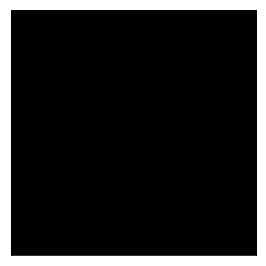

HTTP Response 200
{
    "outputs": {
        "probabilities": [
            [
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                1.0,
                0.0
            ]
        ],
        "classes": [
            8
        ]
    }
}


In [7]:
image = get_image_from_drive('example5.png')
show_selected_image(image)
make_prediction_request(image, endpoint)

In [ ]:
#clean up
if deleteAfter != "0":
    client.deployments.stop(deployment_id)
    tb_client.delete(tb_id)